In [26]:
'''Import COCO Data'''

import sys
sys.path.insert(1, '../coco_dataset')

import coco_handler
import importlib
importlib.reload(coco_handler)

image_detections, detection_data = coco_handler.get_image_detections_and_detection_data()
LABEL_MAP = coco_handler.LABEL_MAP

In [2]:
'''Import Cifar10 Data'''

import cifar10_handler
image_detections, detection_data = cifar10_handler.get_image_detections_and_detection_data()
LABEL_MAP = cifar10_handler.LABEL_MAP

detection_data = detection_data.copy() 
for k,v in detection_data.items():
    detection_data[k] = v / 255.

In [27]:
'''Initialize Data Handler'''

import data_handler
import importlib
importlib.reload(data_handler)

  
target_classes = ['person', 'motorcycle', 'bicycle', 'car', 'bus', 'truck', 'bird', 'cat', 'dog', 'horse', 'zebra', 'sheep', 'handbag', 'umbrella', 'backpack' 'hot dog', 'pizza', 'donut']
#target_classes = None

data_handler_obj = data_handler.DataHandler(
    image_detections, 
    detection_data, 
    target_classes = target_classes, 
    label_map = LABEL_MAP
)

all_object_categories = data_handler_obj.get_all_object_categories()
print(len(all_object_categories), set(all_object_categories))

17585 {'motorcycle', 'pizza', 'bicycle', 'person', 'donut', 'bird', 'handbag', 'umbrella', 'horse', 'bus', 'sheep', 'car', 'dog', 'zebra', 'truck', 'cat'}


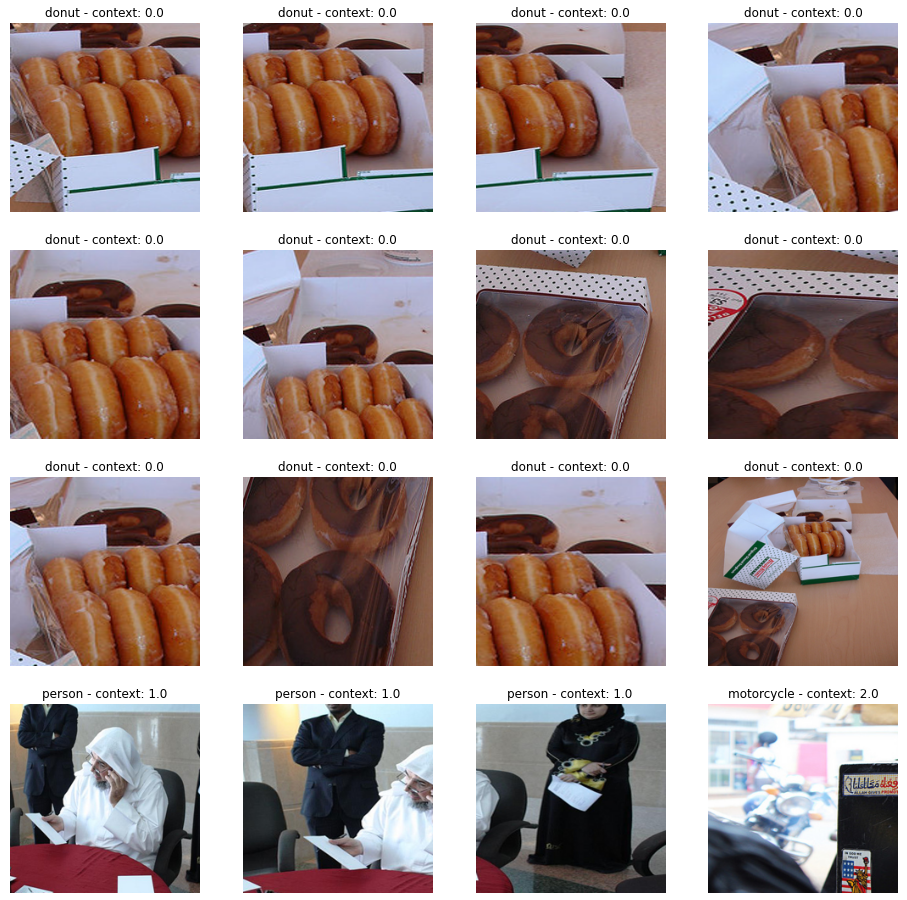

In [28]:
'''Plot elements from data Handler'''

x,y = data_handler_obj.create_batch()
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 16))
plt.axis('off')

columns = 4 
rows = 4
for i in range(1, columns*rows +1):
    img = x[i]
    subplot = fig.add_subplot(rows, columns, i)
    subplot.title.set_text('{} - context: {}'.format(LABEL_MAP.get(y[i][0]), y[i][1]))
    subplot.set_axis_off()
    plt.imshow(img)
plt.show()

In [10]:
'''Create Doublehead model'''

import model_handler
import importlib
importlib.reload(model_handler)

model_handler.create_doublehead_model(
    input_shape = (32,32,3), 
    embedding_size = 128, 
    hidden_layer_neurons = 0, 
    model_name = 'doublehead_model'
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7385

In [ ]:
'''Create Regular model'''

import model_handler
import importlib
importlib.reload(model_handler)

model_hanlder.create_model(
    input_shape = (224,224,3), 
    embedding_size = 256, 
    intermediate_layer_size = 512, 
    model_name = 'final_model_ImageNet'
)

In [2]:
import model_handler
import importlib
importlib.reload(model_handler)

model_handler.save_model_summary('final_model_ImageNet')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [32]:
'''Generate Projector files'''

import model_handler
import importlib
importlib.reload(model_handler)

model_name = 'final_model_ImageNet'

model_handler.generate_projector_files(
    model_name, 
    data_handler_obj, 
    LABEL_MAP, 
    no_samples = 5000, 
    max_category_samples = 400, 
    doublehead_model = False
)

{'person': 3180, 'motorcycle': 98, 'pizza': 75, 'donut': 63, 'bird': 92, 'car': 576, 'umbrella': 144, 'truck': 143, 'bus': 79, 'handbag': 184, 'cat': 46, 'zebra': 88, 'bicycle': 64, 'sheep': 32, 'dog': 63, 'horse': 73}


In [57]:
'''Evaluate model'''

import model_handler
import importlib
importlib.reload(model_handler)

model_handler.evaluate(model_name, data_handler_obj, LABEL_MAP, no_samples = 2000)

{'cat_cat': 0.6552479054007614, 'pizza_cat': 0.6114889401879776, 'bicycle_cat': 0.5916145267829128, 'car_cat': 0.6078623858595187, 'motorcycle_cat': 0.630434331127441, 'bus_cat': 0.6374814989361711, 'truck_cat': 0.6124820177777004, 'donut_cat': 0.5916130952782102, 'dog_cat': 0.5963043715817233, 'bird_cat': 0.6439146494522862, 'pizza_pizza': 0.5084873335770886, 'bicycle_pizza': 0.5408799550282918, 'car_pizza': 0.5442543486508471, 'motorcycle_pizza': 0.5800579297613336, 'bus_pizza': 0.5831674213607264, 'truck_pizza': 0.5485262715949938, 'donut_pizza': 0.49947148701157235, 'dog_pizza': 0.5343560076892526, 'bird_pizza': 0.5753039798984458, 'bicycle_bicycle': 0.4735219987773591, 'car_bicycle': 0.5016063936447174, 'motorcycle_bicycle': 0.5307542187676337, 'bus_bicycle': 0.5502180693003262, 'truck_bicycle': 0.5287703578120928, 'donut_bicycle': 0.5323978358380411, 'dog_bicycle': 0.5180418341157251, 'bird_bicycle': 0.6004924867035518, 'car_car': 0.5137860235802323, 'motorcycle_car': 0.550897767

In [22]:
'''Train model'''

import model_handler
import importlib
importlib.reload(model_handler)

data_handler_obj.add_augmentation(flip=True, rotation=True, translation=True, zoom=True, contrast=False)

model_handler.train_model(
    'doublehead_model', 
    data_handler_obj, 
    new_model_name = 'tripletloss_autoencoder_cifar10', 
    no_epochs = 20, 
    steps_per_epoch = None, 
    learning_rate = 0.001, 
    entity_loss_weight = 1, 
    context_loss_weight = 0,
    reconstruction_loss_weight = 100,
    freeze_backbone = False, 
    doublehead = True
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 128)               4955328   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         7316547   
Total params: 12,271,875
Trainable params: 12,264,195
Non-trainable params: 7,680
_________________________________________________________________
Epoch 1/20
1562/1562 [==============================] - 292s 186ms/step - loss: 4.2011 - encoder_loss: 0.2820 - decoder_loss: 0.0392 3:08 - loss: 5.3670 - encoder_loss
INFO:tensorflow:Assets written to: .\models\tripletloss_autoencoder_cifar10_1631140281.727741\assets
Epoch 2/20
1562/1562 [==============================] - 281s 180ms/step - loss: 2.7834 - encoder_loss: 0.2

In [23]:
'''Train model'''

import model_handler
import importlib
importlib.reload(model_handler)

data_handler_obj.add_augmentation(flip=True, rotation=True, translation=True, zoom=True, contrast=False)

model_handler.train_model(
    'doublehead_model', 
    data_handler_obj, 
    new_model_name = 'autoencoder_cifar10', 
    no_epochs = 20, 
    steps_per_epoch = None, 
    learning_rate = 0.001, 
    entity_loss_weight = 0, 
    context_loss_weight = 0,
    reconstruction_loss_weight = 100,
    freeze_backbone = False, 
    doublehead = True
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 128)               4955328   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         7316547   
Total params: 12,271,875
Trainable params: 12,264,195
Non-trainable params: 7,680
_________________________________________________________________
Epoch 1/20
1562/1562 [==============================] - 286s 182ms/step - loss: 2.4506 - encoder_loss: 0.0000e+00 - decoder_loss: 0.0245s - loss: 2.4937 - encoder_loss: 0.0000e+00 - decoder_loss:  - ETA: 8s - loss: 2.4892 - encoder_loss:  - ETA: 2s - loss: 2.4615 - encoder_loss: 0.0000e+00 - decoder_ - ETA: 0s - loss: 2.4518 - encoder_loss: 0.0000e+00 - decoder_loss: 0.0
I

1562/1562 [==============================] - 282s 180ms/step - loss: 0.5296 - encoder_loss: 0.0000e+00 - decoder_loss: 0.0053 4:39 - loss: 0.5161 - encoder_loss: 0.0000 - ETA: 4:33 - loss: 0.5069 - encoder_loss: 0.0000e+00 - decoder_loss: 0.00 - ETA: 4:33 - loss: 0.5031 - encoder_loss: 0.0000e+0 - ETA: 4:29 - loss: 0.5154 - encoder_loss: 0.0 - ETA: 4:23 - ETA: 4:12 - loss: 0.5059 - encoder_loss: 0.0000e+00 - deco - ETA: 4:09 - loss: 0.5011 - encoder_loss: 0.0 - ETA: 4:03 - loss: 0.5046 - encoder_loss: 0.00 - ETA: 3:58 - loss: 0.5 - ETA: 3:49 - loss: 0.4977 - encoder_lo - ETA - ETA: 3:30 - loss: 0.4956 - encoder_loss: 0.0000e+0 - ETA: 3:26 - loss: 0.4947 - encoder_loss: 0.0000e+00 - decoder_loss: 0.00 - ETA: 3:25 - loss: 0.4946 - encoder_loss: 0.0000e+ - ETA: 3:21 - loss: 0.4937 - encoder_loss: 0.0000e+00 - de - ETA: 3:18 - loss: 0.4932 - encoder_loss - ETA: 3:11 - loss: 0.4921 - encoder_loss: 0.0000e+00 - decoder_ - ETA: 3:09 - loss: 0.4918 - encoder_loss: 0.0000e+00 - decoder_loss: 0.

1562/1562 [==============================] - 281s 180ms/step - loss: 0.3875 - encoder_loss: 0.0000e+00 - decoder_loss: 0.0039 4:36 - loss: 0.3874 - encoder_loss: 0.0000e+00 - dec - ETA: 4:34 - loss: 0.3843 - encoder_loss: 0.0000e+00 - decoder_loss - ETA: 4:33 - loss: 0.3806 - encod - ETA: 4:13 - loss: 0.3945 - encoder_loss: 0.0000e+00 - decoder_lo - ETA: 4:11 - loss: 0.3949 - encoder_loss: 0.0000e+00 - decoder_loss: 0 - ETA: 4:10 - loss: 0.3945 - encoder_loss: 0.0000e+00 - deco - ETA: 4:07  - ETA: 3:57 - loss: 0.3952 - encoder_loss: 0.0000e+00 - - ETA: 3:53 - loss: 0.3946 - encoder_loss: 0.0000 - ETA: 3:48 - loss: 0.3935 - encoder_loss: 0.0000e+00 -  - ETA: - ETA: 3:31 - loss: 0.3927 - encoder_loss: 0.0000e+00 - decoder_loss:  - ETA: 3:30 - loss: 0.3926 - encoder_loss: 0.0000e+00 - decoder_los - ETA: 3:29 - loss: 0.3918 - encoder_loss: 0.0000e+00 - decoder_los - ETA: 3:27 - loss: 0.3913 - encoder_loss: 0. - ETA: 3:21 - loss: 0.3895 - encoder_loss: 0.0000e+00 - decoder_loss:  - ETA: 3:2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


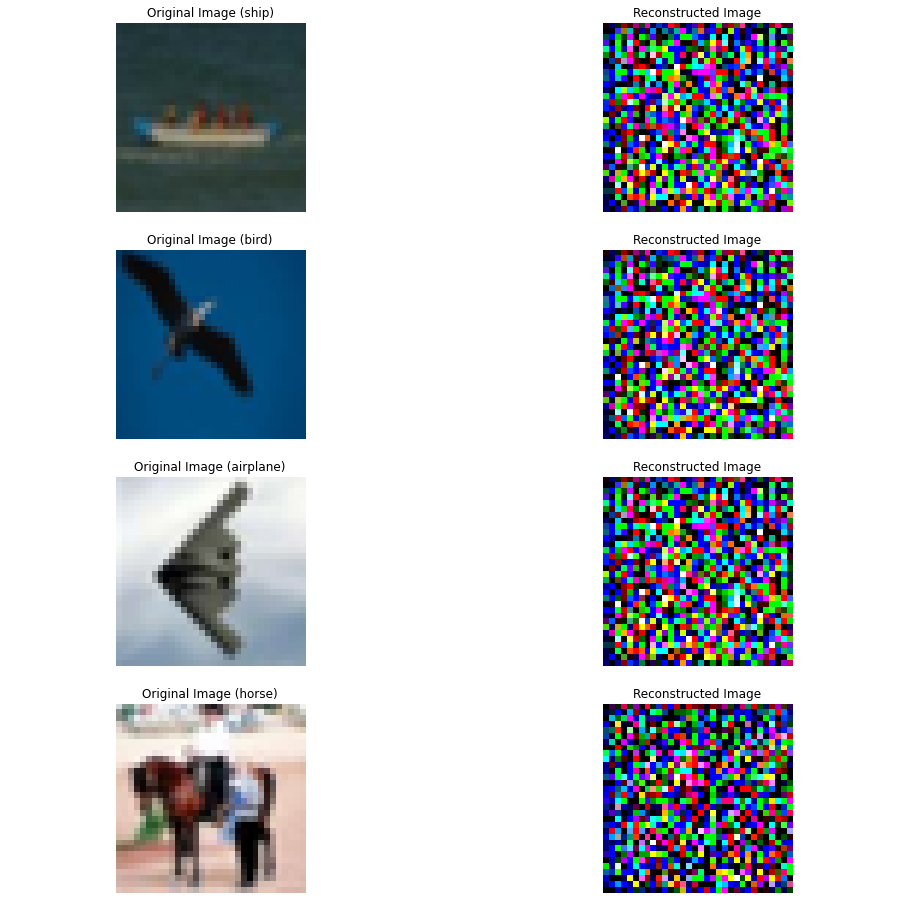

In [30]:
'''inspect Autoencoder performance'''

model_name = 'FULL_TRAIN_tripletloss_cifar10_1631077539.1865098'
data_handler_obj.remove_augmentation()

x,y = data_handler_obj.create_batch(16)
pred = model_handler.predict(model_name, x)

fig = plt.figure(figsize=(16, 16))
plt.axis('off')

reconstructed_images = pred[1]

columns = 2, rows = 4
for i in range(rows):
    img = x[i]
    reconstructed_img = reconstructed_images[i]
    
    subplot = fig.add_subplot(rows, columns, i * 2 + 1)
    subplot.title.set_text('Original Image ({})'.format(LABEL_MAP.get(y[i][0])))
    subplot.set_axis_off()
    plt.imshow(img)
    
    subplot = fig.add_subplot(rows, columns, i * 2 + 2)
    subplot.title.set_text('Reconstructed Image')
    subplot.set_axis_off()
    plt.imshow(reconstructed_img)
plt.show()

